In [18]:
import pandas as pd
import numpy as np
import re
import string
import contractions
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asaines\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asaines\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asaines\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Function to preprocess and tokenize a document
def preprocess_document(doc):
    # Get the default punctuation characters from the string module
    punctuation_pattern = f"[{re.escape(string.punctuation)}]"

    # Handle NA values
    doc = '' if pd.isnull(doc) else doc

    # Remove punctuation using the default pattern
    doc = re.sub(punctuation_pattern, '', doc)

    # Word tokenization using the contractions library
    doc = contractions.fix(doc)
    tokens = doc.split()
    
    #stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]


    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Function to compute coherence values for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        model_list.append(model)
        
        # Compute Coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Sample per year

In [7]:
df = pd.read_csv('abcnews-date-text.csv')
df['year'] = df['publish_date'].astype(str).str[:4]
print(df.year.value_counts(1))
print(df.shape)

year
2013    0.073886
2012    0.071539
2014    0.065530
2008    0.064292
2011    0.062513
2015    0.062121
2007    0.062028
2009    0.061441
2010    0.060225
2005    0.058773
2004    0.058411
2006    0.053771
2003    0.051437
2016    0.049489
2017    0.038186
2020    0.032342
2018    0.032232
2019    0.027375
2021    0.014408
Name: proportion, dtype: float64
(1244184, 3)


In [8]:
# work with the 10%
# Assuming 'year' is the column representing the year in your DataFrame
df_remaining, df_sample = train_test_split(df, test_size=0.01, random_state=42, stratify=df['year'])

In [9]:
# Preprocess the sampled DataFrame
df_sample['processed_tokens'] = df_sample['headline_text'].apply(preprocess_document)
df_sample.head()

,publish_date,headline_text,year,processed_tokens
816719,20130905,data shows ballarat house price fall,2013,"[data, show, ballarat, house, price, fall]"
557895,20100819,quarter of nt to cast vote before election day,2010,"[quarter, nt, cast, vote, election, day]"
1099750,20170924,sunday session: september 24,2017,"[sunday, session, september, 24]"
154411,20050330,questions raised over alcohol management plan,2005,"[question, raised, alcohol, management, plan]"
915681,20141112,ex afl star kerr charged with endangering life...,2014,"[ex, afl, star, kerr, charged, endangering, li..."


In [12]:
# Create Dictionary and Corpus for the sampled data
sampled_id2word = corpora.Dictionary(df_sample['processed_tokens'])
sampled_corpus = [sampled_id2word.doc2bow(text) for text in df_sample['processed_tokens']]


In [13]:
# Build LDA model on the sampled data
lda_model = LdaModel(corpus=sampled_corpus, id2word=sampled_id2word, num_topics=4, random_state=100, update_every=1, 
                            chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[sampled_corpus]

[(0,
  '0.009*"plan" + 0.009*"win" + 0.009*"hospital" + 0.008*"australia" + '
  '0.008*"face" + 0.007*"claim" + 0.006*"qld" + 0.006*"set" + 0.006*"child" + '
  '0.006*"school"'),
 (1,
  '0.022*"police" + 0.016*"new" + 0.010*"council" + 0.009*"australian" + '
  '0.009*"fire" + 0.007*"court" + 0.007*"water" + 0.006*"seek" + 0.006*"crash" '
  '+ 0.006*"woman"'),
 (2,
  '0.016*"man" + 0.011*"death" + 0.011*"call" + 0.011*"govt" + 0.010*"u" + '
  '0.008*"help" + 0.007*"health" + 0.007*"dog" + 0.007*"national" + '
  '0.007*"government"'),
 (3,
  '0.018*"say" + 0.012*"interview" + 0.011*"back" + 0.010*"murder" + '
  '0.009*"first" + 0.008*"report" + 0.007*"sydney" + 0.007*"get" + 0.007*"nsw" '
  '+ 0.006*"rural"')]


In [22]:
# Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(sampled_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sample['processed_tokens'], dictionary=sampled_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -9.428023420228385

Coherence Score:  0.4649612946201914


In [24]:
# Plotting tools
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, sampled_corpus, sampled_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.238303 -0.039372       1        1  26.253853
2     -0.135081 -0.187743       2        1  26.133764
0     -0.075457  0.202806       3        1  24.933204
3     -0.027765  0.024309       4        1  22.679179, topic_info=           Term        Freq       Total Category  logprob  loglift
153      police  387.000000  387.000000  Default  30.0000  30.0000
227         say  273.000000  273.000000  Default  29.0000  29.0000
396         new  280.000000  280.000000  Default  28.0000  28.0000
108         man  274.000000  274.000000  Default  27.0000  27.0000
622       death  202.000000  202.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1927  president   56.497563   57.233770   Topic4  -5.6006   1.4708
234    brisbane   54.343880   55.057609   Topic4  -5.6394   1.4707
58      liberal   51.194972   51.911962   Topic4  -5.6991   1.4698
770       share   51.393041   52.113606   Topic4  -5.6952   1.4698
499      denies   50.219400   50.932804   Topic4  -5.7184   1.4696

[151 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
192       3  0.987924     accused
106       2  0.994705      attack
311       3  0.992927   australia
438       1  0.995533  australian
280       4  0.992954        back
...     ...       ...         ...
314       3  0.992457         win
34        1  0.998260       woman
1108      2  0.995924      worker
996       1  0.989729       world
110       2  0.990772        year

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

## Optimal LDA Topics

In [25]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various numbers of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective numbers of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        
        model_list.append(model)
        
        # Compute Coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=sampled_id2word, corpus=sampled_corpus, texts=df_sample['processed_tokens'], start=2, limit=40, step=3)


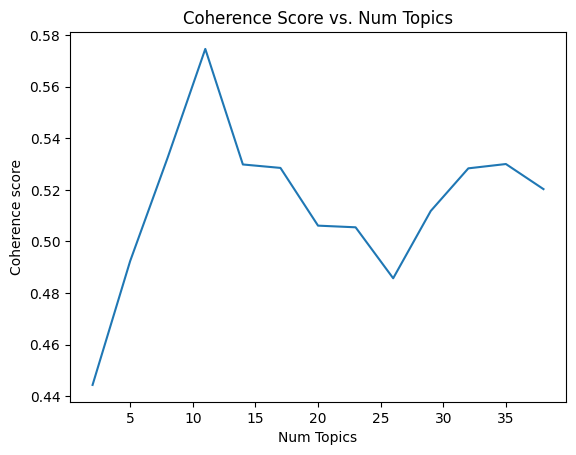

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have coherence_values and x defined
limit = 40
start = 2
step = 3
x = range(start, limit, step)

# Plot using seaborn
sns.lineplot(x=x, y=coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score vs. Num Topics")
plt.show()


In [49]:

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
num_topics=11

Num Topics = 2  has Coherence Value of 0.4444
Num Topics = 5  has Coherence Value of 0.4924
Num Topics = 8  has Coherence Value of 0.5326
Num Topics = 11  has Coherence Value of 0.5746
Num Topics = 14  has Coherence Value of 0.5298
Num Topics = 17  has Coherence Value of 0.5285
Num Topics = 20  has Coherence Value of 0.5061
Num Topics = 23  has Coherence Value of 0.5055
Num Topics = 26  has Coherence Value of 0.4858
Num Topics = 29  has Coherence Value of 0.5118
Num Topics = 32  has Coherence Value of 0.5283
Num Topics = 35  has Coherence Value of 0.53
Num Topics = 38  has Coherence Value of 0.5203


Optimal number of topic 11

In [68]:
# running LDA with 8 topics in sample dataset
lda_model = LdaModel(corpus=sampled_corpus, id2word=sampled_id2word, num_topics=11, random_state=100, update_every=1, 
                            chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, sampled_corpus, sampled_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.380765  0.018742       1        1  13.036241
5     -0.047951 -0.054357       2        1  11.087552
2     -0.065880  0.358654       3        1  11.043646
0     -0.050050 -0.079327       4        1  11.031908
9     -0.050202 -0.118434       5        1  10.481571
8     -0.043100 -0.045520       6        1  10.475036
1     -0.029385 -0.020332       7        1   8.622050
4     -0.026036 -0.017395       8        1   7.424921
3     -0.023613 -0.014648       9        1   6.148044
7     -0.023293 -0.014426      10        1   5.845328
10    -0.021255 -0.012956      11        1   4.803704, topic_info=         Term        Freq       Total Category  logprob  loglift
153    police  489.000000  489.000000  Default  30.0000  30.0000
396       new  360.000000  360.000000  Default  29.0000  29.0000
108       man  337.000000  337.000000  Default  28.0000  28.0000
227       say  362.000000  362.000000  Default  27.0000  27.0000
622     death  262.000000  262.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
904     grand   22.347848   23.328402  Topic11  -4.9760   2.9928
2347     city   22.340685   23.321184  Topic11  -4.9763   2.9928
2643        2   21.168660   22.149186  Topic11  -5.0302   2.9905
1541     heat   20.952609   21.933112  Topic11  -5.0404   2.9900
2564  release   19.918893   20.899400  Topic11  -5.0910   2.9877

[360 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2643     11  0.948116           2
1173      8  0.972756  aboriginal
192       5  0.990194     accused
328       3  0.982299         act
216       9  0.968538      action
...     ...       ...         ...
1231      8  0.983631        work
1108      3  0.994809      worker
996       3  0.994002       world
1999      6  0.989071       worry
110       1  0.991899        year

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 3, 1, 10, 9, 2, 5, 4, 8, 11])

### inference in the whole dataset

In [47]:
# Concatenate the two DataFrames
#df['processed_tokens'] = df['headline_text'].apply(preprocess_document)
print(df.shape)

df.head()



(1244184, 4)


,publish_date,headline_text,year,processed_tokens
0,20030219,aba decides against community broadcasting lic...,2003,"[aba, decides, community, broadcasting, licence]"
1,20030219,act fire witnesses must be aware of defamation,2003,"[act, fire, witness, must, aware, defamation]"
2,20030219,a g calls for infrastructure protection summit,2003,"[g, call, infrastructure, protection, summit]"
3,20030219,air nz staff in aust strike for pay rise,2003,"[air, nz, staff, aust, strike, pay, rise]"
4,20030219,air nz strike to affect australian travellers,2003,"[air, nz, strike, affect, australian, traveller]"


In [43]:
# Infer topics on the full dataset using the existing LDA model
id2word_full = corpora.Dictionary(df['processed_tokens'])
corpus_full = [id2word_full.doc2bow(text) for text in df['processed_tokens']]

In [46]:
# Retrain a new LDA model on the full dataset with the chosen number of topics
lda_model_full = models.LdaModel(corpus=corpus_full,
                                 id2word=id2word_full,
                                 num_topics=num_topics,
                                 random_state=100,
                                 update_every=1,
                                 chunksize=100,
                                 passes=10,
                                 alpha='auto',
                                 per_word_topics=True)

1244184

In [51]:
# Perform inference on the full dataset
#topic_distributions_full, _ = lda_model_full.inference(corpus_full)
topic_distributions_full, _ = lda_model.inference(sampled_corpus)  # done with sample dataset



## Topic evolution over time

In [71]:
# Assuming lda_model is your trained LDA model
# Assuming df is your DataFrame containing the 'year' and 'processed_tokens' columns
# Assign dominant topic to each document
df_sample['dominant_topic'] = [np.argmax(topic_dist) for topic_dist in topic_distributions_full]
#df['dominant_topic'] = [np.argmax(topic_dist) for topic_dist in topic_distributions_full]



In [76]:
from gensim import models
from operator import itemgetter

# Assuming lda_model_full is your trained LDA model on the full dataset
# You may need to adjust the num_topics variable based on the actual number of topics you used
num_topics = 11

# Get the top 10 words for each topic
topic_names = []
for topic_id in range(num_topics):
    # Get the top 10 words for the current topic
    top_words = [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    topic_names.append(top_words)

# Print the extracted top words for each topic
for i, top_words in enumerate(topic_names):
    print(f"Topic {i} Top Words: {', '.join(top_words)}")


Topic 0 Top Words: death, back, australia, attack, child, melbourne, support, time, victim, loss
Topic 1 Top Words: new, court, farmer, flood, case, record, rate, wa, people, show
Topic 2 Top Words: police, call, govt, plan, help, seek, qld, cup, world, worker
Topic 3 Top Words: public, warning, talk, gold, one, killed, fight, bird, want, england
Topic 4 Top Words: interview, nsw, set, car, change, family, climate, park, blaze, appeal
Topic 5 Top Words: australian, claim, government, service, charged, sa, house, labor, could, cut
Topic 6 Top Words: say, council, hospital, health, water, report, year, get, take, minister
Topic 7 Top Words: nt, two, election, premier, day, lead, drought, move, local, ban
Topic 8 Top Words: fire, crash, sydney, woman, rural, drug, driver, open, home, centre
Topic 9 Top Words: man, u, murder, face, dog, national, school, final, accused, fear
Topic 10 Top Words: win, first, arrest, make, team, afl, play, big, leader, mayor


In [77]:
# Assuming you have a list of manually inputted topic names
manual_topic_names = ["Topic_A", "Topic_B", "Topic_C", "Topic_D", "Topic_E", "Topic_F", "Topic_G", "Topic_H", "Topic_I", "Topic_J", "Topic_K"]

# Assuming df_sample is your DataFrame with the 'dominant_topic' column
# Assign the topic names to the 'topic_name' column in the DataFrame
df_sample['topic_name'] = df_sample['dominant_topic'].map(lambda x: manual_topic_names[x])


In [78]:
df_sample.head()

,publish_date,headline_text,year,processed_tokens,dominant_topic,topic_name
816719,20130905,data shows ballarat house price fall,2013,"[data, show, ballarat, house, price, fall]",5,Topic_F
557895,20100819,quarter of nt to cast vote before election day,2010,"[quarter, nt, cast, vote, election, day]",5,Topic_F
1099750,20170924,sunday session: september 24,2017,"[sunday, session, september, 24]",2,Topic_C
154411,20050330,questions raised over alcohol management plan,2005,"[question, raised, alcohol, management, plan]",0,Topic_A
915681,20141112,ex afl star kerr charged with endangering life...,2014,"[ex, afl, star, kerr, charged, endangering, li...",5,Topic_F


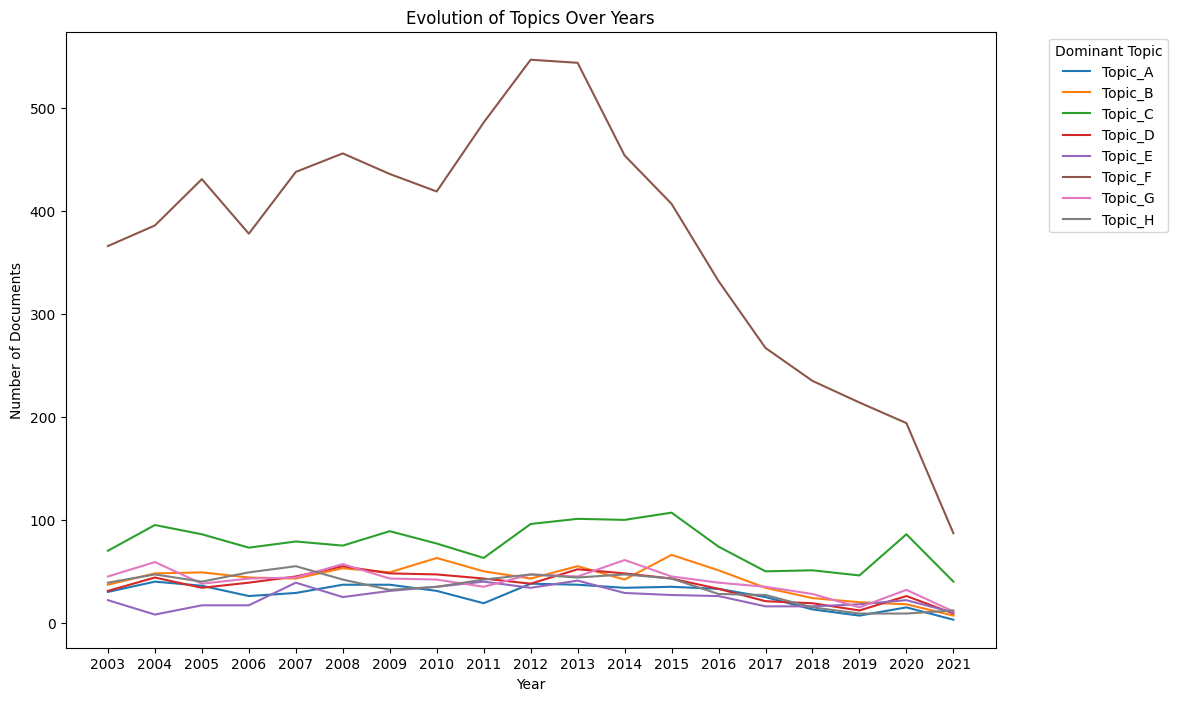

In [81]:
# Assuming df_sample is your DataFrame with the 'topic_name' and 'year' columns

# Group by 'year' and 'topic_name' and calculate the count
topic_counts = df_sample.groupby(['year', 'topic_name']).size().reset_index(name='count')

# Plot the evolution of topics over years using seaborn lineplot
plt.figure(figsize=(12, 8))
sns.lineplot(data=topic_counts, x='year', y='count', hue='topic_name')
plt.title("Evolution of Topics Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Documents")
plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Reference

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0